# Drzewa decyzyjne

In [1]:
import csv
import math
import numpy as np
from treelib import Node, Tree
import graphviz


In [2]:
def count_items(lista, calc_probability=False):
    d = {}
    for elem in lista:
        key = elem[-1]
        if d.get(key) is None:
            d[key] = 0
        d[key]+=1
    if calc_probability:
        for key in d:
            d[key]=d[key]/len(lista)
    return d

def enthropy(prob_dikt):
    ent = 0
    for key in prob_dikt:
        ent += prob_dikt[key] * math.log(prob_dikt[key],2)
    return -ent

def split(table, idx, print_split=True):
    d = {}
    if idx == 3: #jezeli po wieku
        temp = {}
        for passanger in table:
            age = float(passanger[idx])
            if temp.get(age) is None:
                temp[age] = []
            temp[age].append(passanger)
        temp = sorted(temp.items())
        tresshold_candidates = []
        last_state = temp[0][1][0][-1]
        for i, age in enumerate(temp):
            real_age = age[0]
            list_of_passangers_at_age = age[1]
            #print(age)
            if i == 0:
                continue
            probability = count_items(list_of_passangers_at_age, True)
            if probability.get('0', 0) == 1.0 or probability.get('1', 0) == 1.0:#obecny czysty podzbior
                if probability.get(last_state, 0) == 1.0:#ten sam stan jak poprzednio
                    continue
                else:#inny stan niz poprzednio stawiamy thresshold pomiędzy 
                    tresshold_candidates.append((float(real_age)+float(temp[i-1][0]))/2)
                    last_state = '0' if last_state == '1' else '1'
            else:# obecny mieszany podzbior stawiamy thresshold pomiędzy na wszelki wypadek - to tylko kandydat
                tresshold_candidates.append((float(real_age)+float(temp[i-1][0]))/2)
                last_state = 'MIX'
        #wybranie najlepszego thressholda
        best_gain_ratio = -1
        best_tresshold = None
        #print("Tresshold candidates:", tresshold_candidates)
        if len(tresshold_candidates) == 0:
            return { "ALL": table }
        print("==========================================") if print_split else None
        for tresshold in tresshold_candidates:
            less_than_tresshold = []
            greater_equal_tresshold = []
            for passanger in table:
                if float(passanger[idx]) < float(tresshold):
                    less_than_tresshold.append(passanger)
                else:
                    greater_equal_tresshold.append(passanger)
            min_samples_split = 1
            if len(less_than_tresshold) < min_samples_split or len(greater_equal_tresshold) < min_samples_split:
              continue 
            g_ratio = gain_ratio_for_split([less_than_tresshold, greater_equal_tresshold], table)
            print(f"Threshold: {tresshold}") if print_split else None
            print(f"  Sizes: {len(less_than_tresshold)} vs {len(greater_equal_tresshold)}") if print_split else None
            print(f"  Classes <{tresshold}: {count_items(less_than_tresshold)}") if print_split else None
            print(f"  Classes >={tresshold}: {count_items(greater_equal_tresshold)}") if print_split else None
            print(f"  Gain Ratio: {g_ratio:.4f}") if print_split else None
            if g_ratio > best_gain_ratio and tresshold != 1.5:
                best_gain_ratio = g_ratio
                best_tresshold = tresshold
        if best_tresshold is None:
        # Nie ma dobrego progu - zwróć wszystko jako jeden zbiór
            return {"ALL": table}
        #podzial na dwa podzbiory wedlug najlepszego thressholda
        print("\nBest tresshold:", best_tresshold) if print_split else None
        print("==========================================") if print_split else None
        for passanger in table:
            #print("Passanger age:", passanger[idx])
            if float(passanger[idx]) < float(best_tresshold):
                key = "<"+str(best_tresshold)
            else:
                key = ">="+str(best_tresshold)
            if d.get(key) is None:
                d[key] = []
            d[key].append(passanger)
        return d
    #zwykly podzial przy wartościach dyskretnych
    for passanger in table:
        key = passanger[idx]
        if d.get(key) is None:
            d[key] = []
        d[key].append(passanger)
    return d

def conditional_enthropy(table, idx):
    splitted = split(table, idx, print_split=False)
    s = len(table)
    # print(s)
    cond_ent = 0
    for key in splitted:
        podzbior = splitted[key]
        sj = len(podzbior)
        # print(sj)
        ent = enthropy(count_items(podzbior,True))
        # print(ent)
        cond_ent += sj*ent/s
    return cond_ent

def gain(table, idx):
    cond_ent = conditional_enthropy(table,idx)
    ent = enthropy(count_items(table,True))
    return ent - cond_ent

def intrinsic_info(table, idx):
    splitted = split(table, idx, print_split=False)
    s = len(table)
    # print(s)
    cond_ent = 0
    for key in splitted:
        podzbior = splitted[key]
        sj = len(podzbior)
        # print(sj)
        lOg = math.log(sj/s,2)
        # print(ent)
        cond_ent += sj*lOg/s
    return -cond_ent

def gain_ratio(table, idx):
    g = gain(table, idx)
    intr = intrinsic_info(table, idx)
    return 0 if intr == 0 else g / intr

def gain_ratio_for_split(subsets, full_table):
    s = len(full_table)
    ent = enthropy(count_items(full_table, True))
    cond_ent = 0
    split_info = 0
    for subset in subsets:
        sj = len(subset)
        if sj == 0:
            continue
        prob = count_items(subset, True)
        cond_ent += sj * enthropy(prob) / s
        split_info += sj * math.log(sj / s, 2) / s
    gain = ent - cond_ent
    return 0 if split_info == 0 else gain / -split_info

def ID3(table, depth=0):
    best_attr = 0
    best_gain_ratio = -1
    for attr in range(len(table[0])-1):
        g_ratio = gain_ratio(table, attr)
        #print("  " * depth + f"Atrybut: {attr}, Gain ratio: {g_ratio:.4f}")
        if g_ratio > best_gain_ratio:
            best_gain_ratio = g_ratio
            best_attr = attr
    if best_gain_ratio == 0:
        class_counts = count_items(table)
        print("  " * depth + f"Leaf: {class_counts}")
        return
    print("  " * depth + f"Najlepszy atrybut do podziału: {best_attr}, Gain ratio: {best_gain_ratio:.4f}")
    split_table = split(table, best_attr)
    for key in split_table:
        print("  " * depth + f"Podzbior dla klucza: {key}")
        ID3(split_table[key], depth+1)

def ID3_graphviz(table, dot, Atrybuty, label=None, parent_name="root", depth=0, print_attributes=False):
    best_attr = 0
    best_gain_ratio = -1
    for attr in range(len(table[0])-1):
        g_ratio = gain_ratio(table, attr)
        print("  " * depth + f"Atrybut: {attr}, Gain ratio: {g_ratio:.4f}") if print_attributes else None
        if g_ratio > best_gain_ratio:
            best_gain_ratio = g_ratio
            best_attr = attr
    if best_attr < len(Atrybuty):
        attr_name = Atrybuty[best_attr]
    else:
        attr_name = f"Atrybut {best_attr}"
    node_name = f"{attr_name}"
    if depth == 0:
        node_label = "root"
    else:
        node_label = f"{parent_name}_{label}_{depth}"
    if best_gain_ratio == 0 or len(table) == 0:
        class_counts = count_items(table)
        for k in class_counts:
            tag = f"DEAD {class_counts[k]}" if k=='0' else f"SURVIVED {class_counts[k]}"
        node_name = tag
        dot.node(node_label, node_name, shape='box')
        dot.edge(parent_name, node_label, label=str(label))
        return
    split_table = split(table, best_attr, print_split=False)
    dot.node(node_label, node_name)
    if depth != 0:
        dot.edge(parent_name, node_label, label=str(label))
    for key in split_table:
        ID3_graphviz(split_table[key], dot, Atrybuty, str(key), node_label, depth+1, print_attributes=True)

In [3]:
Atrybuty = []
with open('titanic-homework.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    table = []
    for row in spamreader:
        if row[0]==('PassengerId'):
            Atrybuty = [item for i, item in enumerate(row) if i!=2]
            continue
        table.append([item for i, item in enumerate(row) if i!=2 and i!=3])
        #print(table[-1])
    
    # pro = count_items(table, True)
    # print(pro)
    # ent = enthropy(pro)
    # print("Entropia początkowa", ent)
    # cond_ent = conditional_enthropy(table,1)
    # print("Entropia warunkowa po podziale wg 1 atrybutu", cond_ent)
    # print("Gain po podziale wg 1 atrybutu", gain(table,1))
    # print("Gain ratio po podziale wg 1 atr", gain_ratio(,1,))
    

In [4]:
dot = graphviz.Digraph()
ID3_graphviz(table, dot, Atrybuty, print_attributes=True)
dot.render("drzewko", format="png", view=True)  # zapisuje i otwiera plik drzewko.png

Atrybut: 0, Gain ratio: 0.1461
Atrybut: 1, Gain ratio: 0.0596
Atrybut: 2, Gain ratio: 0.4032
Atrybut: 3, Gain ratio: 0.0918
Atrybut: 4, Gain ratio: 0.0251
Atrybut: 5, Gain ratio: 0.0146
  Atrybut: 0, Gain ratio: 0.0880
  Atrybut: 1, Gain ratio: 0.0773
  Atrybut: 2, Gain ratio: 0.0000
  Atrybut: 3, Gain ratio: 0.0942
  Atrybut: 4, Gain ratio: 0.0203
  Atrybut: 5, Gain ratio: 0.0351
    Atrybut: 0, Gain ratio: 0.0686
    Atrybut: 1, Gain ratio: 0.0616
    Atrybut: 2, Gain ratio: 0.0000
    Atrybut: 3, Gain ratio: 0.0434
    Atrybut: 4, Gain ratio: 0.0061
    Atrybut: 5, Gain ratio: 0.1360
      Atrybut: 0, Gain ratio: 0.0478
      Atrybut: 1, Gain ratio: 0.0848
      Atrybut: 2, Gain ratio: 0.0000
      Atrybut: 3, Gain ratio: 0.0327
      Atrybut: 4, Gain ratio: 0.0179
      Atrybut: 5, Gain ratio: 0.0000
        Atrybut: 0, Gain ratio: -0.0000
        Atrybut: 1, Gain ratio: 0.0000
        Atrybut: 2, Gain ratio: 0.0000
        Atrybut: 3, Gain ratio: 0.0000
        Atrybut: 4, Gain ra

'drzewko.png'

In [5]:
#ID3(table)

## Komentarz




- Aleksander Kamiński 155840
- Piotr Nowacki 155906

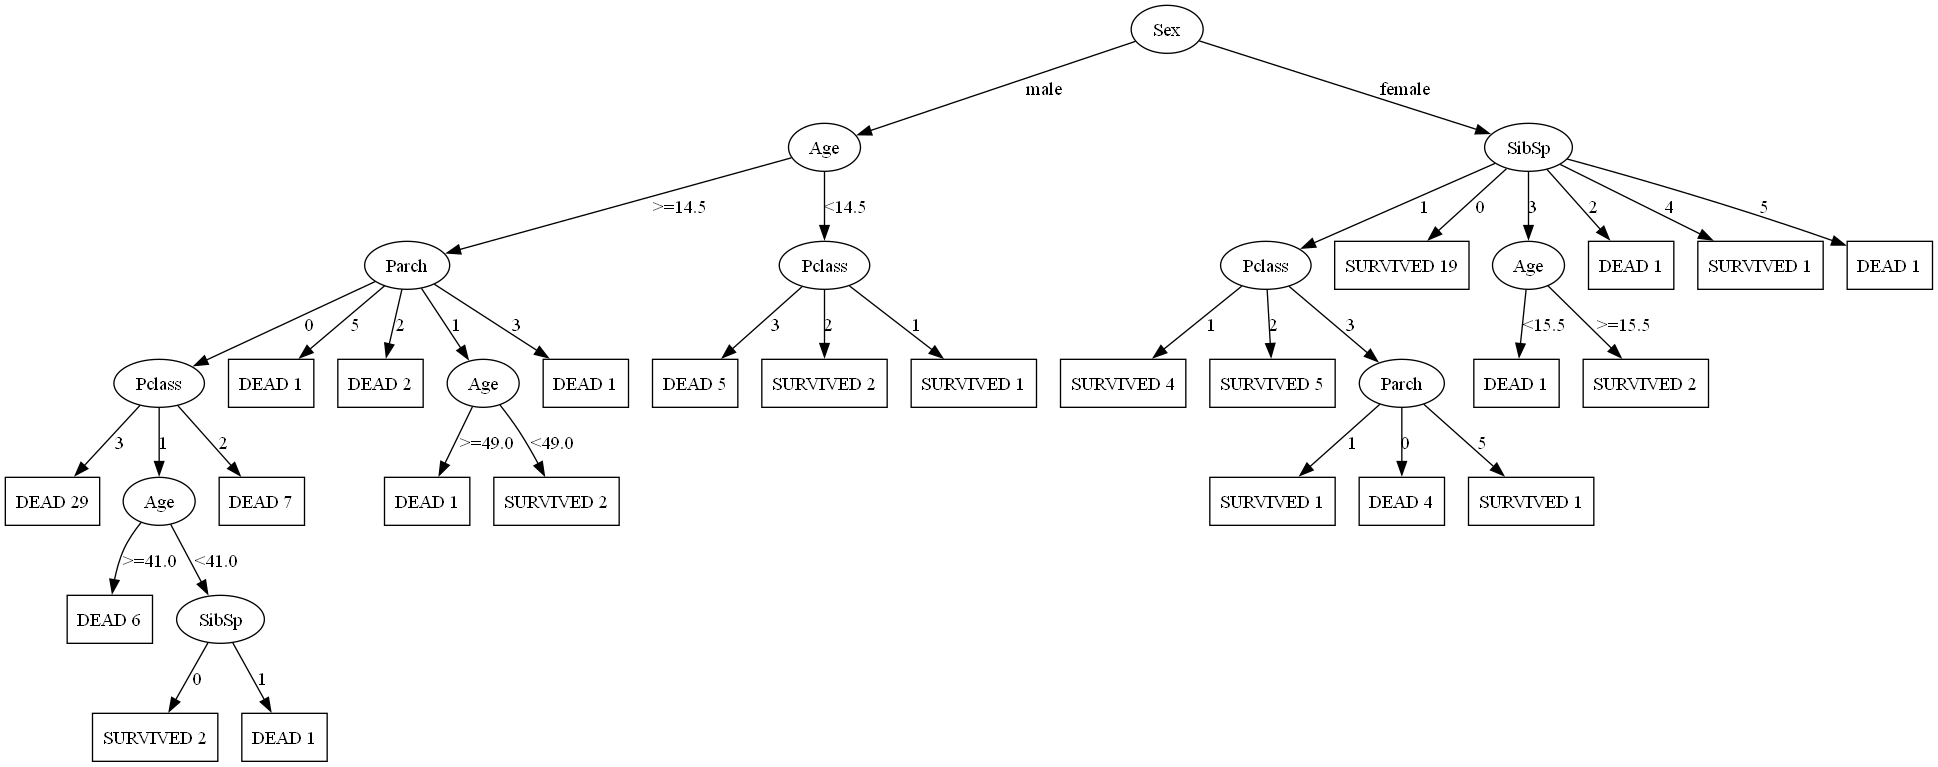

In [6]:
from IPython.display import Image

Image(filename='drzewko.png')

Algorytm ID3 na tym zbiorze danych najpierw podzielił pasażerów według płci — atrybut Sex został wybrany jako pierwszy (gain ratio = 0.4032).

Dla gałęzi male kolejnym najlepszym atrybutem był Age z progiem 14.5 lat (gain ratio = 0.0942).

- Dla mężczyzn młodszych niż 14.5 roku (podgałąź < 14.5) następnie wybrany został atrybut Pclass; każda z trzech wartości Pclass doprowadziła do liścia (jednoznacznej klasy decyzyjnej).

- Dla mężczyzn starszych lub równych 14.5 roku (podgałąź >= 14.5) kolejnym podziałem był Parch. Dla wartości Parch ∈ {5, 2, 3} powstały liście. Gdy Parch = 1, dokonano dodatkowego podziału według wieku z progiem 49 lat, co doprowadziło do dwóch liści.

- Dla mężczyzn z Parch = 0 konieczny był dalszy podział względem Pclass — dla klas 2 i 3 powstały liście; w obrębie klasy 1 dokonano kolejnego podziału według progu wieku 41 lat (jedna gałąź stała się liściem), natomiast w młodszej grupie (wiek < 41) konieczne było jeszcze rozdzielenie względem SibSp, co doprowadziło do ostatecznych dwóch liści na tej części drzewa.

Dla gałęzi female kolejnym wybranym atrybutem był SibSp (liczba rodzeństwa/małżonków na pokładzie).

- W zależności od wartości SibSp drzewo dzieli się na podzbiory: dla niektórych wartości (0, 2, 4, 5) od razu otrzymujemy liście, natomiast dla innych wymagana jest dalsza dekompozycja.

- Dla kobiet z SibSp = 3 przeprowadzono dodatkowy podział według Age z progiem 15.5 lat, co dało dwie liście.

- Dla kobiet z SibSp = 1 nastąpił podział według Pclass — wartości 1 i 2 dały liście, natomiast dla klasy 3 konieczny był dodatkowy podział według Parch, co wygenerowało trzy ostatnie liście w drzewie.

Podsumowując, drzewo decyzyjne budowane przez algorytm ID3 na tym zbiorze danych najpierw rozdziela pasażerów według płci, a następnie w każdej z grup wybiera kolejne atrybuty, które najlepiej rozdzielają dane pod względem przeżycia, aż do uzyskania końcowych, jednoznacznych decyzji.

Co ciekawe, przez odpowiedni dobór argumentów udało się uniknąć podziału przez PassengerID.

Wybraliśmy projekt na ocenę 5.0, z tego powodu pojawiły się problemy związane z podziałem zbioru - jednak udało się je rozwiązać poprzez dodanie parametru min_samples_split.